In [1]:
import os
import glob
import joblib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from scipy.stats import zscore
from os.path import join as pjoin
from sklearn.decomposition import PCA
from utils import get_roi_data, save_ciftifile, conv2_labels, save2cifti

In [2]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
corr_path = os.path.join(wk_dir, 'build/featurewise-corr')
voxel_mask_path = os.path.join(wk_dir, 'prep/voxel_masks/')

subs = [f'sub-0{i+1}' for i in list(range(9))]
bmaskname = 'subjvis'
layername = 'googlenet-conv2'
modelname = 'RFmodels'

mask_name = 'primaryvis-in-MMP'
voxel_mask_nii = nib.load(os.path.join(voxel_mask_path, f'nod-voxmask_{mask_name}.dlabel.nii'))
voxel_mask = np.squeeze(voxel_mask_nii.get_fdata())
voxel_indices = np.where(voxel_mask==1)[0]

# generate specific ROI
v1_voxels = np.array([ _ for _ in np.where(get_roi_data(None, 'V1')==1)[0] if _ in voxel_indices])
v2_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V2')==1)[0] if _ in voxel_indices])
v3_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V3')==1)[0] if _ in voxel_indices])
v4_voxels = np.array([ _ for _ in  np.where(get_roi_data(None, 'V4')==1)[0] if _ in voxel_indices])

sharing_repeats = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj-repeats.dscalar.nii')).get_fdata()
mask_gmm = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_gmmret-in-subj.dlabel.nii')).get_fdata()
mask_fix = nib.load(os.path.join(voxel_mask_path, 'nod-voxmask_fixret-in-subj.dlabel.nii')).get_fdata()
np.unique(sharing_repeats), mask_gmm.shape

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), (9, 59412))

In [58]:
indexname = 'full-model-ev-train'

dots_color = {'full-model-r':'#00CEE0', 'full-model-r-train':'#00838F',
              'full-model-ev':'#F96E46', 'full-model-ev-train':'#ECB009',}
cor_path = os.path.join(wk_dir, 'build/featurewise-corr')
model_folders = ['', 'oncesig', 'doublesig', 'singlesig',  'conv1-pca', 'conv1-pca-nonlinear','conv2-pca']
model_performance = {}
for model_folder in model_folders:
    modelcor_path = os.path.join(cor_path, model_folder)
    filepattern =os.path.join(modelcor_path, f"sub-*/*{indexname}.npy")
    files = glob.glob(filepattern)
    cors = []
    files = sorted(files)
    for file in files:
        corr = np.load(file)
        cors.append(corr)
        # print(file.split('/')[-1], ':', np.nanmin(corr), np.nanmax(corr))
        # print(file.split('/')[-1], ':', corr.shape)
    model_performance[model_folder] = np.stack(cors, axis=0)

    print(model_performance[model_folder].shape)

(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)
(9, 1, 59412)


In [60]:
import scipy.stats as stats
show_roi = np.array([_ for _ in v1_voxels if _ in np.where(sharing_repeats>5)[1]])

# model_folders = ['', 'doublesig', 'singlesig']'singlesig',  'pca'
testcors = model_performance['singlesig']
ctrlcors = model_performance['pca']

data1 = testcors[:,0,show_roi].reshape(-1)
data2 = ctrlcors[:,0,show_roi].reshape(-1)
notnan_vertex = list(set(np.where(np.isnan(data1)==0)[0]) & set(np.where(np.isnan(data2)==0)[0]))
model1, model0 = data1[np.array(notnan_vertex)], data2[np.array(notnan_vertex)]
# 执行配对t检验
t_stat, p_value = stats.ttest_rel(model1, model0, alternative='two-sided')
diff = np.mean(model1-model0)
# confidence_interval  = stats.ttest_rel(model1, model0, alternative='greater').confidence_interval()
# 输出结果
print(f'######{indexname}#####')
print("-------ALL.Subj-------")
print("t-statistic:", t_stat)
print("DiffMean:", diff, ' DataShape', model1.shape, model0.shape)
# print("95%CI:", confidence_interval)
print("p-value:", p_value)

for isub, sub in enumerate(subs):

    sig_roi = show_roi #np.array([_ for _ in show_roi if _ in np.where(fullmodel_sig[isub]==1)[0]]) 

    data1 = testcors[isub,0,sig_roi].reshape(-1)
    data2 = ctrlcors[isub,0,sig_roi].reshape(-1)
    notnan_vertex = list(set(np.where(np.isnan(data1)==0)[0]) & set(np.where(np.isnan(data2)==0)[0]))
    # 执行配对t检验
    model1, model0 = data1[np.array(notnan_vertex)], data2[np.array(notnan_vertex)]
    t_stat, p_value = stats.ttest_rel(model1, model0, alternative='two-sided')
    diff = np.mean(model1-model0)
    # confidence_interval  = stats.ttest_rel(model1, model0, alternative='greater').confidence_interval()

    # 输出结果
    print(f"-------{sub}---------")
    print("t-statistic:", t_stat)
    print("DiffMean:", diff, ' DataShape', model1.shape, model0.shape)
    # print("95%CI:", confidence_interval)
    print("p-value:", p_value)

######full-model-ev#####
-------ALL.Subj-------
t-statistic: -6.011268569574127
DiffMean: -0.000991132831686293  DataShape (7497,) (7497,)
p-value: 1.9270132955899144e-09
-------sub-01---------
t-statistic: -0.6063540490022515
DiffMean: -0.00021853197208839944  DataShape (833,) (833,)
p-value: 0.5444450749603618
-------sub-02---------
t-statistic: -6.804560420020156
DiffMean: -0.003132384644877858  DataShape (833,) (833,)
p-value: 1.937819363292123e-11
-------sub-03---------
t-statistic: -11.494819102348433
DiffMean: -0.005757061572287298  DataShape (833,) (833,)
p-value: 1.7411153631913518e-28
-------sub-04---------
t-statistic: -10.515601300030207
DiffMean: -0.005065301331228779  DataShape (833,) (833,)
p-value: 2.2833417072990437e-24
-------sub-05---------
t-statistic: 21.65570428433749
DiffMean: 0.008215764788297983  DataShape (833,) (833,)
p-value: 7.91717303519476e-83
-------sub-06---------
t-statistic: 19.235735230765723
DiffMean: 0.01078656462501767  DataShape (833,) (833,)
p-v

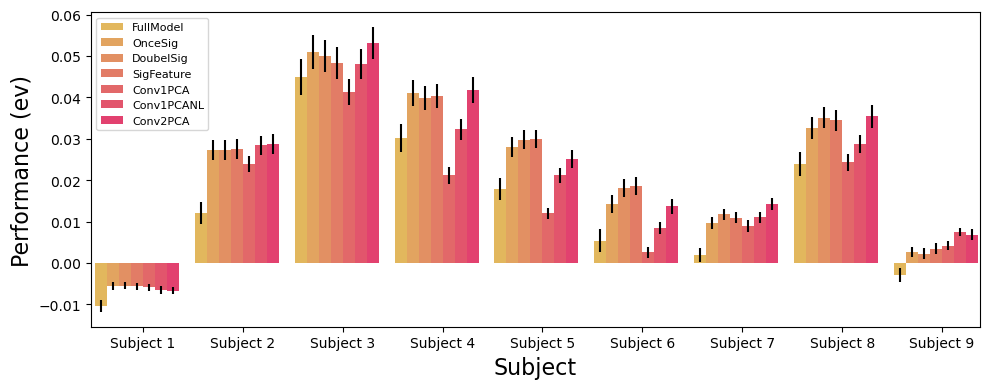

In [22]:
# 示例数据：9个被试，3种模型
n_subjects = 9
n_models = 7

show_roi = v1_voxels # np.array([_ for _ in v1_voxels if _ in np.where(sharing_repeats>5)[1]])

# 每个被试在每种模型下的数据
performance = np.zeros((n_subjects, n_models)) # 平均性能
errors = np.zeros((n_subjects, n_models)) # 误差数据
# model_folders = ['', 'singlesig', 'doublesig']
for i, model_folder in enumerate(model_folders): 
    performance[:,i] = np.nanmean(model_performance[model_folder][:,0,show_roi],axis=1)
    errors[:,i] = 1.96 * np.nanstd(model_performance[model_folder][:,0,show_roi],axis=1) / np.sqrt(len(show_roi))

# 模型名称和颜色
models = ['FullModel', 'OnceSig', 'DoubelSig', 'SigFeature', 'Conv1PCA', 'Conv1PCANL', 'Conv2PCA']
colors = ["#e2b75d","#e2a460","#e29063","#e27c66","#e26869","#e2556c","#e2416f"]
#["#feae46","#f99458","#f47b6a","#ef617d","#ea488f","#e52ea1"]
#["#ffa446","#fa8761","#f5697c","#f04c97","#eb2eb2"]#["#ffc2bf","#ff9793","#ff6666"]#['red', 'blue']

# 绘制条形图
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10,4))

# 为每个模型生成条形图
bar_width = 0.12  # 条形的宽度
for i in range(n_models):
    # 计算每个条形的位置
    indices = np.arange(n_subjects) + i * bar_width
    # 绘制条形图
    ax.bar(indices, performance[:, i], bar_width, label=models[i], color=colors[i], yerr=errors[:, i])

# 设置图表标题和标签
ax.set_xlabel('Subject', fontsize=16)
indexlabel = indexname.replace('full-model-', '')
ax.set_ylabel(f'Performance ({indexlabel})', fontsize=16)
# ax.set_title('Average Performance of Each Model per Subject')
ax.set_xticks(np.arange(n_subjects) + len(models) * bar_width / 2)
ax.set_xticklabels(['Subject {}'.format(i+1) for i in range(n_subjects)], fontsize=10)
ax.set_xlim([-0.1, 8.8])
ax.legend(fontsize=8)
plt.tight_layout()
# 显示图表
plt.show()

In [34]:
(performance[:,1] / performance[:,0]), performance[:,2] / performance[:,0]

(array([0.61825573, 0.72677222, 0.68530633, 0.63420767, 0.56595542,
        0.57349487, 0.68776179, 0.6332381 , 0.63707985]),
 array([0.51860645, 0.64552023, 0.57780755, 0.51882312, 0.44793282,
        0.46377087, 0.59056744, 0.53221848, 0.52478974]))

### 相对值考察
全模型存在过拟合（训练集拟合较好，测试集拟合较差）
将所有模型的表现与全模型做相对比较

In [21]:
model_performance[''].shape

(9, 1, 59412)

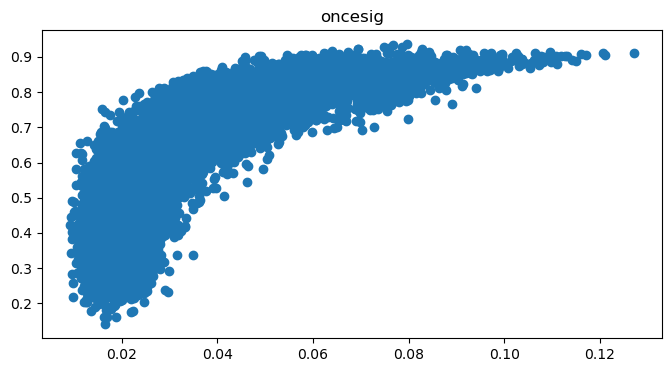

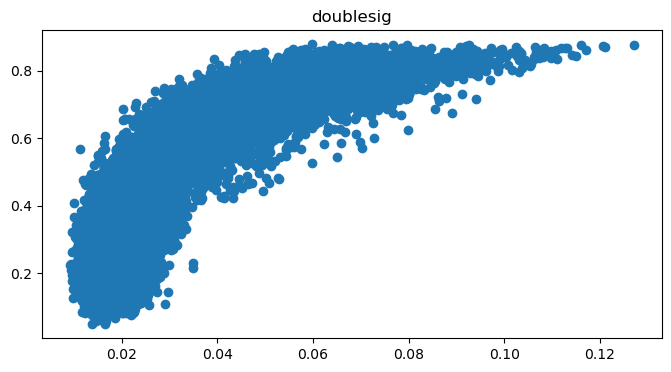

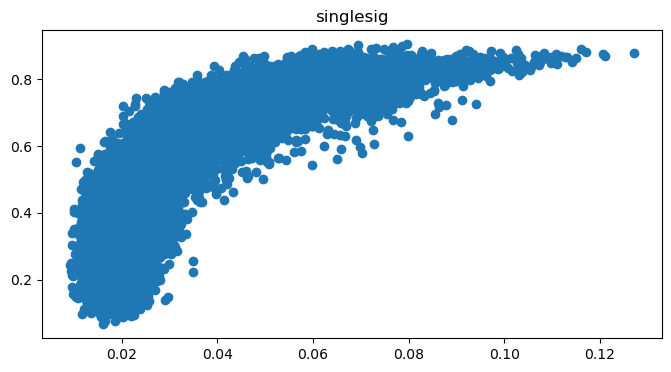

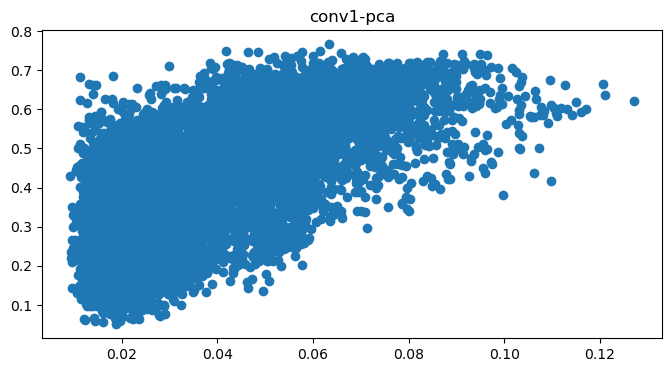

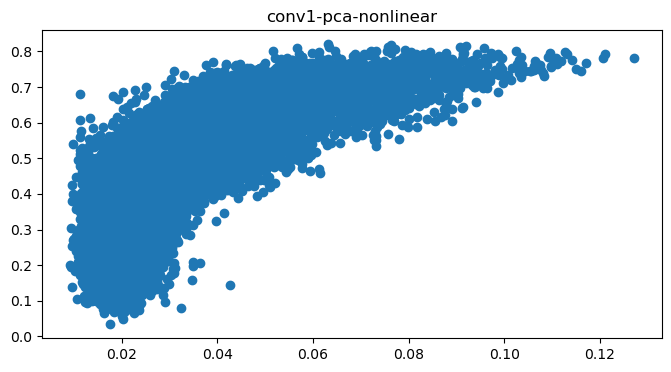

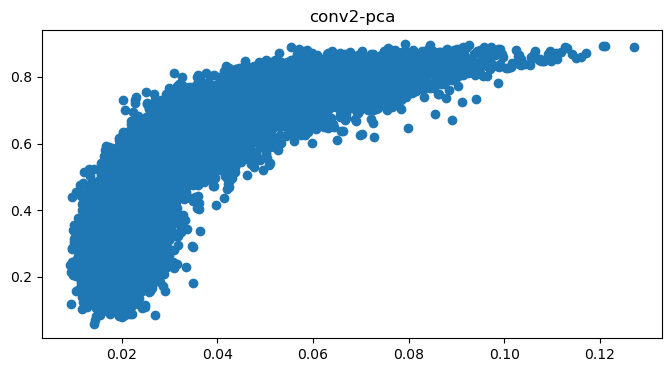

In [59]:
for i_index, model_folder in enumerate(model_folders[1::]):
    show_roi = v1_voxels
    
    base = model_performance[''][:,0,show_roi]
    RPI = model_performance[model_folder][:,0,show_roi] / base
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(8,4))
    ax.scatter(base , RPI)
    # ax.set_ylim([np.nanpercentile(RPI, 30), 1.5])
    ax.set_title(model_folder)
    plt.show()


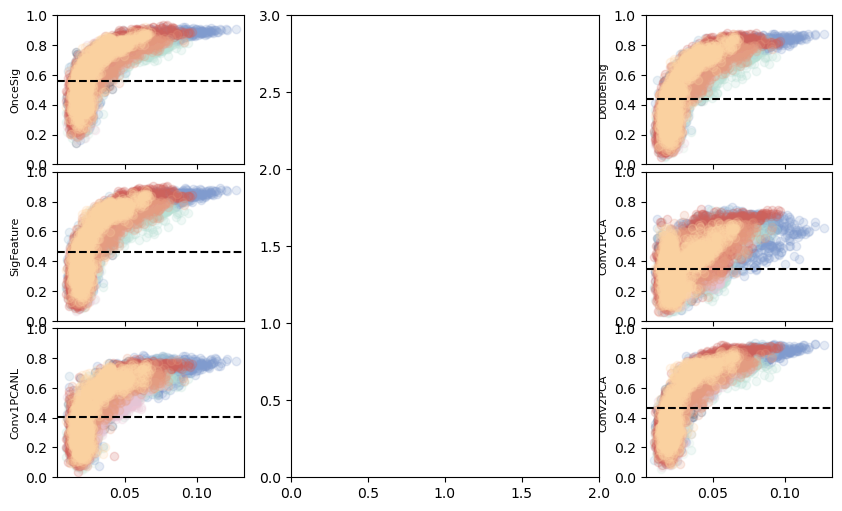

In [88]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_subplot(ax, data, label, color='blue'):
    ax.scatter(data[0], data[1], alpha=0.2, color=color)
    # ax.axhline(np.nanmean(data[1]), ls='--', color=color)
    ax.set_ylim([0, 1])
    ax.set_ylabel(label, fontsize=8)

# 创建整体布局
fig = plt.figure(figsize=(10, 6))  # 整体长宽比为4:3

# 定义布局，包括2行和4列，用于7个子图
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.05)

# 创建A类子图，一共6个，按照3行2列的方式排列
axes = []
for i in range(3):
    for j in [0, 3]:
        ax = plt.subplot(gs[i, j])
        axes.append(ax)

show_roi = v1_voxels
modelsubmeanpri = np.nan*np.zeros((len(model_folders[1::]), len(subcolors)))
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
for i_index, model_folder in enumerate(model_folders[1::]): 
    for isub in range(len(subcolors)):
        base = model_performance[''][:, 0, show_roi][isub]
        RPI = model_performance[model_folder][:, 0, show_roi][isub] / base
        plot_subplot(axes[i_index], (base, RPI), models[i_index + 1], subcolors[isub])

    base = model_performance[''][:, 0, show_roi]
    RPI = model_performance[model_folder][:, 0, show_roi] / base
    axes[i_index].axhline(np.nanmean(RPI), ls='--', color='black')

# 创建B类子图，一个，放在整个画面的中间
ax_b = plt.subplot(gs[0:3, 1:3])

ax_b.set_aspect('equal')
ax_b.set_xlim(0, 2)
ax_b.set_ylim(0, 3)

# 调整布局，使得A类子图分布在B类子图的左右两侧
# gs.tight_layout(fig, rect=[0, 0, 1, 1])

# 显示图形
plt.show()

(9, 1628)